# BTC Predictor

In [514]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [515]:
from fastai.structured import *
from fastai.column_data import *
np.set_printoptions(threshold=50, edgeitems=20)
from ta import *
from IPython.display import HTML

## Stock Predictor Lib


In [516]:
import json as js
import numpy as np
import pandas as pd
from ta import *
#from fastai.structured import *
#from fastai.column_data import *


class StockPredictor:

    def __init__(self, df, index):
        self.df = df
        self.index = index

    # ///////////////////////////////
    # /////// DATA CLEANING /////////
    # ///////////////////////////////

    def sample_train(self, sampleSize):
        self.train = self.df.tail(sampleSize)
        print('Train size: ' + str(len(self.train)) +
              ' Original size: ' + str(len(self.df)))

    def set_date_as_index(self):
        self.train[self.index] = pd.to_datetime(self.train[self.index])

    def set_date_as_index_unix(self):
        self.train[self.index] = pd.to_datetime(
            self.train[self.index], unit='s')

    def split_train_validation(self, testRecordsCount, trainRecordsCount):
        self.test = self.train.tail(testRecordsCount)
        self.train = self.train.head(trainRecordsCount)
#        self.test.reset_index(inplace=True)
#        self.train.reset_index(inplace=True)
        print('Train size: ' + str(len(self.train)) +
              ' Test size: ' + str(len(self.test)))

    def normalize_train(self, volume, open, high, low, close):
        self.train = pd.DataFrame({
            'Timestamp': self.train[self.index],
            'Volume': self.train[volume],
            'Open': self.train[open],
            'High': self.train[high],
            'Low': self.train[low],
            'Close': self.train[close]
        })[['Timestamp', 'Volume', 'Open', 'High', 'Low', 'Close']]

    def clean_train(self):
        #     df = df.dropna()
        #     df = df.replace(np.nan,df.mean())
        self.train = self.train.replace([np.inf, -np.inf], np.nan)
        self.train = self.train.fillna(method='bfill')
        print('Train size: ' + str(len(self.train)))

    # ///////////////////////////////
    # //// FEATURE ENGINEERING //////
    # ///////////////////////////////

    def get_max_lookback(self, target, lookback):
        return self.train[target].rolling(window=lookback, min_periods=1).max()

    def add_ta(self):
        self.train = add_all_ta_features(
            self.train, "Open", "High", "Low", "Close", "Volume", fillna=True)
        self.train['maxc5'] = self.get_max_lookback("Close", 5)
        self.train['maxc15'] = self.get_max_lookback("Close", 15)
        self.train['maxc30'] = self.get_max_lookback("Close", 30)
        self.train['maxc60'] = self.get_max_lookback("Close", 60)
        self.train['maxc90'] = self.get_max_lookback("Close", 90)
        self.train['maxh5'] = self.get_max_lookback("High", 5)
        self.train['maxh15'] = self.get_max_lookback("High", 15)
        self.train['maxh30'] = self.get_max_lookback("High", 30)
        self.train['maxh60'] = self.get_max_lookback("High", 60)
        self.train['maxh90'] = self.get_max_lookback("High", 90)

    """ Set the target (dependent variable) by looking ahead in a certain time window and percent increase
        to determine if the action should be a BUY or a SELL. BUY is true/1 SELL is false/0"""

    def set_target(self, target, lookahead, percentIncrease):
        #        ,win_type='boxcar'
        max_lookahead = self.train[target] \
            .iloc[::-1] \
            .rolling(window=lookahead, min_periods=1) \
            .max() \
            .iloc[::-1]
        self.train['action'] = max_lookahead > (
            percentIncrease * self.train['Close'])
#        self.train['max'] =max_in_lookahead_timeframe
        self.train.action = self.train.action.astype(int)
        buy_count = str(len(self.train[self.train.action == 1]))
        sell_count = str(len(self.train[self.train.action == 0]))
        print('Buy count: ' + buy_count + ' Sell count: ' + sell_count)

    def set_target_hold(self, target, lookahead, percentIncrease):
        self.train['action'] = 0
        max_lookahead = self.train[target] \
            .iloc[::-1] \
            .rolling(window=lookahead, min_periods=1) \
            .max() \
            .iloc[::-1]
        self.train.loc[max_lookahead > self.train['Close'], 'action'] = 1

        self.train.loc[max_lookahead > percentIncrease *
                       self.train['Close'], 'action'] = 2

        self.train.action = self.train.action.astype(int)
        sell_count = str(len(self.train[self.train.action == 0]))
        hold_count = str(len(self.train[self.train.action == 1]))
        buy_count = str(len(self.train[self.train.action == 2]))
        print('Buy count: ' + buy_count + ' Sell count: ' +
              sell_count + ' Hold count: ' + hold_count)

    def add_date_values(self):
        add_datepart(self.train, 'Timestamp', drop=False)
        self.train['hour'] = self.train['Timestamp'].dt.hour
        self.train['minute'] = self.train['Timestamp'].dt.minute
    def set_target_historical(self, target, lookback, percentIncrease):
        max_in_lookback_timeframe = self.get_max_lookback(target, lookback)
        self.train['action'] = max_in_lookback_timeframe > (
            percentIncrease * self.train['Close'])
        self.train.action = self.train.action.astype(int)
        buy_count = str(len(self.train[self.train.action == 1]))
        sell_count = str(len(self.train[self.train.action == 0]))
        print('Buy count: ' + buy_count + ' Sell count: ' + sell_count)

    def set_target_historical_hold(self, target, lookback, percentIncrease):
        self.train['action'] = 0
        max_lookback = self.get_max_lookback(target, lookback)
        self.train.loc[max_lookback > self.train['Close'], 'action'] = 1

        self.train.loc[max_lookback > percentIncrease *
                       self.train['Close'], 'action'] = 2

        self.train.action = self.train.action.astype(int)
        sell_count = str(len(self.train[self.train.action == 0]))
        hold_count = str(len(self.train[self.train.action == 1]))
        buy_count = str(len(self.train[self.train.action == 2]))
        print('Buy count: ' + buy_count + ' Sell count: ' +
              sell_count + ' Hold count: ' + hold_count)

    def add_date_values(self):
        add_datepart(self.train, 'Timestamp', drop=False)
        self.train['hour'] = self.train['Timestamp'].dt.hour
        self.train['minute'] = self.train['Timestamp'].dt.minute

    # ///////////////////////////////
    # ///////// EVALUATION //////////
    # ///////////////////////////////

    def generate_net_profit_result(self, df, startAmount, totalBuys, totalSells):
        startClose = df.Close.iloc[0]
        endClose = df.Close.iloc[-1]
        endBuyAmount = df.buyAmount.iloc[-1]
        endSellAmount = df.sellAmount.iloc[-1]
        endAmount = endBuyAmount if (
            endBuyAmount > 0) else (endSellAmount * endClose)
        buyAndHoldPercentIncrease = ((endClose - startClose)/startClose) * 100
        percentIncrease = ((endAmount - startAmount)/startAmount) * 100
        percentDifference = percentIncrease - buyAndHoldPercentIncrease

        result = {
            'startClose': startClose,
            'endClose': endClose,
            'startAmount': startAmount,
            'endAmount': endAmount,
            'buyAndHoldPercentIncrease': round(buyAndHoldPercentIncrease, 3),
            'percentIncrease': round(percentIncrease, 3),
            'percentDifference': round(percentDifference, 3),
            'totalTrades': totalBuys + totalSells
        }
        return result

    def calculate_accuracy(self, df):
        successful_predictions = df.loc[df.action == df.predicted]
        total_accuracy = len(successful_predictions)/len(df)
        total_buy_actions = df.loc[df.action == 1]
        total_sell_actions = df.loc[df.action == 0]
        successful_buy_predictions = successful_predictions.loc[successful_predictions.action == 1]
        successful_sell_predictions = successful_predictions.loc[successful_predictions.action == 0]
        buy_accuracy = len(successful_buy_predictions)/len(total_buy_actions)
        sell_accuracy = (len(successful_sell_predictions) /
                         len(total_sell_actions))
        f1Score = (buy_accuracy + sell_accuracy)/2
        result = {
            'F1Score': round(f1Score, 3),
            'totalAccuracy': round(total_accuracy, 3),
            'buyAccuracy': round(buy_accuracy, 3),
            'sellAccuracy': round(sell_accuracy, 3),
            'totalBuyActions': len(total_buy_actions),
            'successfulBuyPredictions': len(successful_buy_predictions)
        }
        return result

    def calculate_net_profit(self, inputDf, startAmount, fee):
        df = inputDf
        df['buyAmount'] = 0
        df['sellAmount'] = 0
        totalBuys = 0
        totalSells = 0
        for index, row in df.iterrows():
            prevBuyAmount = df.buyAmount.get(index - 1, np.nan)
            prevSellAmount = df.sellAmount.get(index - 1, np.nan)
            predicted = row.predicted
            if index == df.index[0]:
                df.loc[index, 'buyAmount'] = startAmount
            elif predicted == 1 and prevBuyAmount > 0:
                # BUY
                base_sell = prevBuyAmount/row.Close
                df.loc[index, 'sellAmount'] = base_sell - (base_sell * fee)
                totalBuys += 1
            elif predicted == 1 and prevBuyAmount == 0:
                df.loc[index, 'sellAmount'] = prevSellAmount
            elif predicted == 0 and prevSellAmount > 0:
                # SELL
                base_buy = prevSellAmount*row.Close
                df.loc[index, 'buyAmount'] = base_buy - (base_buy*fee)
                totalSells += 1
            elif predicted == 0 and prevSellAmount == 0:
                df.loc[index, 'buyAmount'] = prevBuyAmount
            else:
                raise ValueError(
                    'This is weird, invalid predicted value: ' + str(predicted) + ' prevSellAmount: ' +
                    str(prevSellAmount) + ' prevBuyAmount: ' + str(prevBuyAmount))
        result = self.generate_net_profit_result(
            df, startAmount, totalBuys, totalSells)
        self.net_profit_df = df
        self.result = result
        # print(js.dumps(result, sort_keys=False, indent=4, separators=(',', ': ')))

    def calculate_net_profit_hold(self, inputDf, startAmount, fee):
        df = inputDf
        df['buyAmount'] = 0
        df['sellAmount'] = 0
        totalBuys = 0
        totalSells = 0
        for index, row in df.iterrows():
            prevBuyAmount = df.buyAmount.get(index - 1, np.nan)
            prevSellAmount = df.sellAmount.get(index - 1, np.nan)
            predicted = row.predicted
            if index == df.index[0]:
                df.loc[index, 'buyAmount'] = startAmount
            elif predicted == 2 and prevBuyAmount > 0:
                # BUY
                base_sell = prevBuyAmount / row.Close
                df.loc[index, 'sellAmount'] = base_sell - (base_sell * fee)
                totalBuys += 1
            elif predicted == 2 and prevBuyAmount == 0:
                df.loc[index, 'sellAmount'] = prevSellAmount
            elif predicted == 0 and prevSellAmount > 0:
                # SELL
                base_buy = prevSellAmount * row.Close
                df.loc[index, 'buyAmount'] = base_buy - (base_buy*fee)
                totalSells += 1
            elif predicted == 0 and prevSellAmount == 0:
                df.loc[index, 'buyAmount'] = prevBuyAmount
            elif predicted == 1:
                # HOLD
                df.loc[index, 'buyAmount'] = prevBuyAmount
                df.loc[index, 'sellAmount'] = prevSellAmount
            else:
                raise ValueError(
                    'This is weird, invalid predicted value: ' + str(predicted))

        result = self.generate_net_profit_result(
            df, startAmount, totalBuys, totalSells)
        self.net_profit_df = df
        self.result = result
        # print(js.dumps(result, sort_keys=False, indent=4, separators=(',', ': ')))

    # ///////////////////////////////
    # /////////// UTIL //////////////
    # ///////////////////////////////

    def save_to_feather(self):
        self.train.reset_index(inplace=True)
        self.train.to_feather(f'{PATH}train')

    def read_from_feather(self):
        self.train = pd.read_feather(f'{PATH}train')
        # train.drop(self.index,1,inplace=True)

    """ usage conflateTimeFrame(df, '5T') """

    def conflate_time_frame(self, df, timeFrame):
        ohlc_dict = {
            'Open': 'first',
            'High': 'max',
            'Low': 'min',
            'Close': 'last',
            'Volume': 'sum'
        }
        return df.resample(timeFrame).agg(ohlc_dict)

    def plot_profit(self, df):
        df.plot(
            x='Timestamp',
            y=['Close', 'buyAmount'],
            style='o',
            figsize=(10, 5),
            grid=True)


## Config


In [517]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

index='Timestamp'
# index='time_period_start'
lookahead = 10
percentIncrease = 1.002
recordsCount = 110000
testRecordsCount = 5000
trainRecordsCount = 105000
trainRatio = 0.9
lr = 1e-4
dropout = 0.06
modelName = 'btcBinaryClassificationModel'
dep = 'action'
PATH='data/stock/'

## Create datasets

In [518]:
table_names = [
    'coinbaseUSD_1-min_data_2014-12-01_to_2018-06-27',
#     'bitstampUSD_1-min_data_2012-01-01_to_2018-06-27',
#     'btc-bitstamp-2012-01-01_to_2018-01-08'
#         'BTC_COINBASE_2018-07-25_09-06'
#         'ETH_COINBASE_07-21_08-24'
]

In [519]:
tables = [pd.read_csv(f'{PATH}{fname}.csv', low_memory=False) for fname in table_names]

In [520]:
for t in tables: display(t.head())

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1417411980,300.0,300.0,300.0,300.0,0.01,3.0,300.0
1,1417412040,300.0,300.0,300.0,300.0,0.01,3.0,300.0
2,1417412100,300.0,300.0,300.0,300.0,0.01,3.0,300.0
3,1417412160,300.0,300.0,300.0,300.0,0.01,3.0,300.0
4,1417412220,300.0,300.0,300.0,300.0,0.01,3.0,300.0


In [521]:
train= tables[0]

In [522]:
p = StockPredictor(train, index)
p.sample_train(recordsCount)

Train size: 110000 Original size: 1819074


In [523]:
p.save_to_feather()

## Data Cleaning

In [524]:
p.read_from_feather()
p.set_date_as_index_unix()

In [525]:
p.normalize_train('Volume_(BTC)','Open','High','Low','Close')
p.train.head()

,Timestamp,Volume,Open,High,Low,Close
0,2018-04-11 14:41:00,1.658177,6950.01,6950.01,6950.00,6950.01
1,2018-04-11 14:42:00,9.377500,6950.01,6950.01,6949.91,6949.92
2,2018-04-11 14:43:00,6.000195,6949.91,6949.91,6945.99,6946.00
3,2018-04-11 14:44:00,1.164831,6946.00,6946.00,6944.99,6945.00
4,2018-04-11 14:45:00,0.513527,6945.00,6945.00,6944.99,6944.99


## Join Bitstamp

In [526]:
# bitstamp= tables[1].tail(recordsCount)
# bitstamp[index] = pd.to_datetime(bitstamp[index], unit='s')
# bitstampExtract = pd.DataFrame({
#     'BitstampTimestamp':bitstamp.Timestamp,
#     'BitstampClose':bitstamp.Close,
# })[[ 'BitstampTimestamp','BitstampClose']] 
# bitstampExtract = bitstampExtract.reset_index(drop=True)
# p.train = pd.concat([bitstampExtract, p.train], axis=1)

In [527]:
# valpred = valpred.reset_index(drop=True)
# train = train.set_index(pd.DatetimeIndex(train[index]))
# p.train = p.conflate_time_frame(p.train, '5T')
# len(train)

## Feature Engineering

In [528]:
p.set_target('Close',lookahead, percentIncrease)

Buy count: 19028 Sell count: 90972


In [529]:
# add technical analysis
p.add_ta()
p.clean_train()

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ta/trend.py:607: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  aroon_up = close.rolling(n).apply(lambda x: float(np.argmax(x) + 1) / n * 100)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ta/trend.py:629: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  aroon_down = close.rolling(n).apply(lambda x: float(np.argmin(x) + 1) / n * 100)


Train size: 110000


In [530]:
p.add_date_values()

## Split validation and test sets

In [531]:
p.split_train_validation(testRecordsCount, trainRecordsCount)

Train size: 105000 Test size: 5000


In [532]:
p.train.head()

,Timestamp,Volume,Open,High,Low,Close,action,volume_adi,volume_obv,volume_obvm,volume_cmf,volume_fi,volume_em,volume_vpt,volume_nvi,volatility_atr,volatility_bbh,volatility_bbl,volatility_bbm,volatility_bbhi,volatility_bbli,volatility_kcc,volatility_kch,volatility_kcl,volatility_kchi,volatility_kcli,volatility_dch,volatility_dcl,volatility_dchi,volatility_dcli,trend_macd,trend_macd_signal,trend_macd_diff,trend_ema_fast,trend_ema_slow,trend_adx,trend_adx_pos,trend_adx_neg,trend_adx_ind,trend_vortex_ind_pos,trend_vortex_ind_neg,trend_vortex_diff,trend_trix,trend_mass_index,trend_cci,trend_dpo,trend_kst,trend_kst_sig,trend_kst_diff,trend_ichimoku_a,trend_ichimoku_b,trend_aroon_up,trend_aroon_down,trend_aroon_ind,momentum_rsi,momentum_mfi,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,others_dr,others_dlr,others_cr,maxc5,maxc15,maxc30,maxc60,maxc90,maxh5,maxh15,maxh30,maxh60,maxh90,TimestampYear,TimestampMonth,TimestampWeek,TimestampDay,TimestampDayofweek,TimestampDayofyear,TimestampIs_month_end,TimestampIs_month_start,TimestampIs_quarter_end,TimestampIs_quarter_start,TimestampIs_year_end,TimestampIs_year_start,TimestampElapsed,hour,minute
0,2018-04-11 14:41:00,1.658177,6950.01,6950.01,6950.00,6950.01,0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,1000.000000,0.0,6951.063567,6936.719433,6943.8915,0.0,0.0,6946.251333,6946.762333,6945.740333,0.0,0.0,6950.01,6938.0,0.0,0.0,0.0,0.0,0.0,6945.9025,6939.493077,40.0,20.0,20.0,0,1.0,1.0,0.0,0.0,25.0,0.0,0.0,0.0,0.0,0.0,6930.755,6933.505,0.0,0.0,0.0,50.0,50.0,0.0,50.0,50.0,50.0,-50.0,0.0,0.000000,0.000000,0.000000,6950.01,6950.01,6950.01,6950.01,6950.01,6950.01,6950.01,6950.01,6950.01,6950.01,2018,4,15,11,2,101,False,False,False,False,False,False,1523457660,14,41
1,2018-04-11 14:42:00,9.377500,6950.01,6950.01,6949.91,6949.92,0,-5.843823,-9.377500,0.0,0.0,0.000000,0.0,0.000000,1000.000000,0.0,6951.063567,6936.719433,6943.8915,0.0,0.0,6946.251333,6946.762333,6945.740333,0.0,0.0,6950.01,6938.0,0.0,0.0,0.0,0.0,0.0,6945.9025,6939.493077,40.0,20.0,20.0,0,1.0,1.0,0.0,0.0,25.0,0.0,0.0,0.0,0.0,0.0,6930.755,6933.505,0.0,0.0,0.0,50.0,50.0,-100.0,50.0,50.0,50.0,-50.0,0.0,-0.001295,-0.001295,-0.001295,6950.01,6950.01,6950.01,6950.01,6950.01,6950.01,6950.01,6950.01,6950.01,6950.01,2018,4,15,11,2,101,False,False,False,False,False,False,1523457720,14,42
2,2018-04-11 14:43:00,6.000195,6949.91,6949.91,6945.99,6946.00,0,-13.471581,-6.000195,0.0,0.0,-17.411492,0.0,-0.003506,999.435965,0.0,6951.063567,6936.719433,6943.8915,0.0,0.0,6946.251333,6946.762333,6945.740333,0.0,0.0,6950.01,6938.0,0.0,0.0,0.0,0.0,0.0,6945.9025,6939.493077,40.0,20.0,20.0,0,1.0,1.0,0.0,0.0,25.0,0.0,0.0,0.0,0.0,0.0,6930.755,6933.505,0.0,0.0,0.0,50.0,50.0,-100.0,50.0,50.0,50.0,-50.0,0.0,-0.056404,-0.056419,-0.057698,6950.01,6950.01,6950.01,6950.01,6950.01,6950.01,6950.01,6950.01,6950.01,6950.01,2018,4,15,11,2,101,False,False,False,False,False,False,1523457780,14,43
3,2018-04-11 14:44:00,1.164831,6946.00,6946.00,6944.99,6945.00,0,-7.111346,-1.164831,0.0,0.0,40.406332,0.0,-0.003552,999.292078,0.0,6951.063567,6936.719433,6943.8915,0.0,0.0,6946.251333,6946.762333,6945.740333,0.0,0.0,6950.01,6938.0,0.0,0.0,0.0,0.0,0.0,6945.9025,6939.493077,40.0,20.0,20.0,0,1.0,1.0,0.0,0.0,25.0,0.0,0.0,0.0,0.0,0.0,6930.755,6933.505,0.0,0.0,0.0,50.0,50.0,-100.0,50.0,50.0,50.0,-50.0,0.0,-0.014397,-0.014398,-0.072086,6950.01,6950.01,6950.01,6950.01,6950.01,6950.01,6950.01,6950.01,6950.01,6950.01,2018,4,15,11,2,101,False,False,False,False,False,False,1523457840,14,44
4,2018-04-11 14:45:00,0.513527,6945.00,6945.00,6944.99,6944.99,0,-1.655292,-0.513527,0.0,0.0,5.541534,0.0,-0.000168,999.290639,0.0,6951.063567,6936.719433,6943.8915,0.0,0.0,6946.251333,6946.762333,6945.740333,0.0,0.0,6950.01,6938.0,0.0,0.0,0.0,0.0,0.0,6945.9025,6939.493077,40.0,20.0,20.0,0,1.0,1.0,0.0,0.0,25.0,0.0,0.0,0.0,0.0,0.0,6930.755,6933.505,0.0,0.0,0.0,50.0,50.0,-100.0,50.0,50.0,50.0,-50.0,0.0,-0.000144,-0.000144,-0.072230,6950.01,6950.01,6950.01,6950.01,6

In [533]:
p.train.tail(50).T.head(100)

,104950,104951,104952,104953,104954,104955,104956,104957,104958,104959,104960,104961,104962,104963,104964,104965,104966,104967,104968,104969,104970,104971,104972,104973,104974,104975,104976,104977,104978,104979,104980,104981,104982,104983,104984,104985,104986,104987,104988,104989,104990,104991,104992,104993,104994,104995,104996,104997,104998,104999
Timestamp,2018-06-23 11:51:00,2018-06-23 11:52:00,2018-06-23 11:53:00,2018-06-23 11:54:00,2018-06-23 11:55:00,2018-06-23 11:56:00,2018-06-23 11:57:00,2018-06-23 11:58:00,2018-06-23 11:59:00,2018-06-23 12:00:00,2018-06-23 12:01:00,2018-06-23 12:02:00,2018-06-23 12:03:00,2018-06-23 12:04:00,2018-06-23 12:05:00,2018-06-23 12:06:00,2018-06-23 12:07:00,2018-06-23 12:08:00,2018-06-23 12:09:00,2018-06-23 12:10:00,2018-06-23 12:11:00,2018-06-23 12:12:00,2018-06-23 12:13:00,2018-06-23 12:14:00,2018-06-23 12:15:00,2018-06-23 12:16:00,2018-06-23 12:17:00,2018-06-23 12:18:00,2018-06-23 12:19:00,2018-06-23 12:20:00,2018-06-23 12:21:00,2018-06-23 12:22:00,2018-06-23 12:23:00,2018-06-23 12:24:00,2018-06-23 12:25:00,2018-06-23 12:26:00,2018-06-23 12:27:00,2018-06-23 12:28:00,2018-06-23 12:29:00,2018-06-23 12:30:00,2018-06-23 12:31:00,2018-06-23 12:32:00,2018-06-23 12:33:00,2018-06-23 12:34:00,2018-06-23 12:35:00,2018-06-23 12:36:00,2018-06-23 12:37:00,2018-06-23 12:38:00,2018-06-23 12:39:00,2018-06-23 12:40:00
Volume,0.708867,10.6586,1.83397,0.5509,2.79515,5.02459,0.672095,0.719216,29.7732,43.8382,22.0712,0.640054,10.5955,1.5952,0.612352,34.9729,21.2464,9.08557,2.71753,7.58063,2.01577,41.2956,1.6795,1.435,2.72171,0.2069,0.493633,0.4866,0.3422,0.672276,0.217541,0.513476,0.2488,0.910394,2.8414,2.06006,0.4269,0.93773,0.67812,0.4896,0.479676,0.263432,10.0313,1.56485,4.45439,0.255699,0.755953,17.9088,4.69728,1.8578
Open,6150,6150,6149.99,6150,6150,6150,6154.26,6154.27,6159.18,6149.98,6132.19,6130,6134.6,6130.26,6130.26,6130.25,6109.29,6108.99,6113.37,6108.1,6107.22,6102.74,6097.89,6103.78,6103.81,6109.34,6109.35,6109.35,6109.34,6109.99,6109.99,6109.99,6109.99,6110,6110,6113.6,6114.1,6114.1,6114.21,6114.21,6114.2,6114.21,6114.21,6114.59,6114.58,6130.71,6129.52,6129.53,6132.69,6128.51
High,6150,6150,6150,6150,6150,6154.32,6154.26,6159.18,6159.18,6149.98,6132.19,6134.61,6135,6130.26,6130.26,6130.25,6113.42,6113.42,6113.38,6108.71,6107.23,6102.74,6103.36,6103.9,6109.35,6109.35,6109.35,6109.35,6110,6110,6110,6110,6110,6110,6113.6,6114.1,6114.1,6114.22,6114.22,6114.21,6114.21,6114.21,6114.59,6114.59,6130.71,6130.71,6129.53,6132.02,6132.69,6128.51
Low,6149.99,6149.99,6149.99,6150,6149.99,6150,6154.26,6154.27,6147.01,6124.13,6129.16,6130,6132.25,6130.01,6130.25,6103.87,6100.44,6108.99,6108.83,6101.1,6101.1,6087.38,6097.89,6103.78,6103.81,6109.34,6109.34,6109.34,6109.34,6109.99,6109.99,6109.99,6109.99,6109.99,6109.99,6113.59,6114.09,6114.1,6114.2,6114.2,6114.2,6114.2,6113,6110.01,6114.58,6128.21,6129.52,6129.52,6128.5,6128.51
Close,6149.99,6150,6150,6150,6150,6154.26,6154.26,6159.18,6150.75,6125.22,6130,6134.6,6132.25,6130.25,6130.26,6112,6106.24,6113.41,6108.83,6107.23,6107.18,6095.79,6103.36,6103.79,6106.43,6109.35,6109.34,6109.34,6110,6110,6110,6109.99,6109.99,6109.99,6113.6,6114.1,6114.1,6114.22,6114.2,6114.2,6114.21,6114.2,6114.59,6114.59,6130.71,6128.5,6129.53,6132.02,6128.51,6128.51
action,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0
volume_adi,-0.708867,9.94978,12.4926,1.83397,2.79515,7.68017,4.88501,0.719216,-10.7546,-51.615,-49.9749,-9.19644,-9.95822,-9.12792,2.07994,-12.8041,-15.6753,6.78569,6.32702,1.91453,6.61494,5.90812,5.60473,0.483667,-1.34322,0.059515,-0.286733,-0.980233,-0.1444,1.01448,0.889818,-0.295935,-0.762276,-1.15919,1.931,4.90146,2.48696,1.36463,0.25961,-1.16772,-0.00992415,0.216243,9.7679,11.5962,6.01925,4.25802,0.559576,18.6648,13.234,-4.67485
volume_obv,-0.708867,10.6586,0,0,0,5.02459,0,0.719216,-29.7732,-43.8382,22.0712,0.640054,-10.5955,-1.5952,0.612352,-34.9729,-21.2464,9.08557,-2.71753,-7.58063,-2.01577,-41.2956,1.6795,1.435,2

## Create features

Identify categorical vs continuous variables

In [534]:
cat_vars = ['TimestampYear', 'TimestampMonth', 'TimestampWeek', 'TimestampDay', 'hour','minute', 'TimestampDayofweek',
'TimestampDayofyear','TimestampIs_month_end', 'TimestampIs_month_start', 'TimestampIs_quarter_end',
'TimestampIs_quarter_start','TimestampIs_year_end', 'TimestampIs_year_start']

# 'BitstampClose',
contin_vars = ['Open', 'Close','High', 'Low', 'Volume', 'TimestampElapsed',
'volume_adi','volume_obv','volume_obvm','volume_cmf','volume_fi','volume_em','volume_vpt','volume_nvi',
'volatility_atr','volatility_bbh','volatility_bbl','volatility_bbm',
               'volatility_bbhi',
               'volatility_bbli',
'volatility_kcc','volatility_kch','volatility_kcl','volatility_kchi','volatility_kcli','volatility_dch',
'volatility_dcl','volatility_dchi',
               'volatility_dcli',
               'trend_macd','trend_macd_signal','trend_macd_diff',
'trend_ema_fast','trend_ema_slow','trend_adx','trend_adx_pos','trend_adx_neg','trend_adx_ind','trend_vortex_ind_pos',
'trend_vortex_ind_neg','trend_vortex_diff','trend_trix','trend_mass_index','trend_cci','trend_dpo','trend_kst',
'trend_kst_sig','trend_kst_diff','trend_ichimoku_a','trend_ichimoku_b'
,'trend_aroon_up','trend_aroon_down','trend_aroon_ind','momentum_rsi','momentum_mfi','momentum_tsi',
'momentum_uo','momentum_stoch','momentum_stoch_signal','momentum_wr','momentum_ao','others_dr','others_dlr','others_cr'
,'maxc5','maxc15','maxc30','maxc60','maxc90','maxh5','maxh15','maxh30','maxh60','maxh90']


n = len(p.train); n

p.test = p.test.set_index('Timestamp')
p.train = p.train.set_index('Timestamp')

len(contin_vars),len(contin_vars) -5

(74, 69)

In [535]:
p.train = p.train[cat_vars+contin_vars+[dep]].copy()
# , index

In [536]:
# test[dep] = 0 
p.test = p.test[cat_vars+contin_vars+[dep]].copy()
# , index


In [537]:
for v in cat_vars: p.train[v] = p.train[v].astype('category').cat.as_ordered()
#     todo: maybe change dep variable to category here for multiclass option

In [538]:
apply_cats(p.test, p.train)
# test

In [539]:
for v in contin_vars:
    p.train[v] = p.train[v].astype('float32')
    p.test[v] = p.test[v].astype('float32')

In [540]:
df, y, nas, mapper = proc_df(p.train, dep, do_scale=True)

In [541]:
df_test, _, nas, mapper = proc_df(p.test, dep, do_scale=True, mapper=mapper, na_dict=nas)
p.train.head(30).T.head(70)

Timestamp,2018-04-11 14:41:00,2018-04-11 14:42:00,2018-04-11 14:43:00,2018-04-11 14:44:00,2018-04-11 14:45:00,2018-04-11 14:46:00,2018-04-11 14:47:00,2018-04-11 14:48:00,2018-04-11 14:49:00,2018-04-11 14:50:00,2018-04-11 14:51:00,2018-04-11 14:52:00,2018-04-11 14:53:00,2018-04-11 14:54:00,2018-04-11 14:55:00,2018-04-11 14:56:00,2018-04-11 14:57:00,2018-04-11 14:58:00,2018-04-11 14:59:00,2018-04-11 15:00:00,2018-04-11 15:01:00,2018-04-11 15:02:00,2018-04-11 15:03:00,2018-04-11 15:04:00,2018-04-11 15:05:00,2018-04-11 15:06:00,2018-04-11 15:07:00,2018-04-11 15:08:00,2018-04-11 15:09:00,2018-04-11 15:10:00
TimestampYear,2018,2018,2018,2018,2018,2018,2018,2018,2018,2018,2018,2018,2018,2018,2018,2018,2018,2018,2018,2018,2018,2018,2018,2018,2018,2018,2018,2018,2018,2018
TimestampMonth,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
TimestampWeek,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15
TimestampDay,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11
hour,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,15,15,15,15,15,15,15,15,15,15,15
minute,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,0,1,2,3,4,5,6,7,8,9,10
TimestampDayofweek,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
TimestampDayofyear,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101,101
TimestampIs_month_end,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
TimestampIs_month_start,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [542]:
nas={}

In [543]:
df.head(2)

,TimestampYear,TimestampMonth,TimestampWeek,TimestampDay,hour,minute,TimestampDayofweek,TimestampDayofyear,TimestampIs_month_end,TimestampIs_month_start,TimestampIs_quarter_end,TimestampIs_quarter_start,TimestampIs_year_end,TimestampIs_year_start,Open,Close,High,Low,Volume,TimestampElapsed,volume_adi,volume_obv,volume_obvm,volume_cmf,volume_fi,volume_em,volume_vpt,volume_nvi,volatility_atr,volatility_bbh,volatility_bbl,volatility_bbm,volatility_bbhi,volatility_bbli,volatility_kcc,volatility_kch,volatility_kcl,volatility_kchi,volatility_kcli,volatility_dch,volatility_dcl,volatility_dchi,volatility_dcli,trend_macd,trend_macd_signal,trend_macd_diff,trend_ema_fast,trend_ema_slow,trend_adx,trend_adx_pos,trend_adx_neg,trend_adx_ind,trend_vortex_ind_pos,trend_vortex_ind_neg,trend_vortex_diff,trend_trix,trend_mass_index,trend_cci,trend_dpo,trend_kst,trend_kst_sig,trend_kst_diff,trend_ichimoku_a,trend_ichimoku_b,trend_aroon_up,trend_aroon_down,trend_aroon_ind,momentum_rsi,momentum_mfi,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,others_dr,others_dlr,others_cr,maxc5,maxc15,maxc30,maxc60,maxc90,maxh5,maxh15,maxh30,maxh60,maxh90
Timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-04-11 14:41:00,1,1,1,11,15,42,3,1,1,1,1,1,1,1,-1.119895,-1.119883,-1.12163,-1.118065,-0.306346,-1.732113,-0.022722,0.008246,0.021475,-0.149857,0.010366,-0.023417,0.004728,-1.737869,-0.994084,-1.134219,-1.118407,-1.126554,-0.246965,-0.253434,-1.123914,-1.12694,-1.120861,-0.079835,-0.060822,-1.132308,-1.119766,-0.447444,-0.394879,0.006751,0.00719,-0.000174,-1.124364,-1.131295,-0.554513,-0.65489,-0.696795,-0.951299,-0.038384,-0.00178,-0.420791,0.008376,0.215777,-0.010777,-0.00123,0.005068,0.005161,0.000038,-1.140341,-1.137575,-1.32808,-1.326607,-0.003181,-0.038923,0.01427,-0.034426,-0.104974,-0.07413,-0.079337,-0.07413,0.005495,0.000984,0.001409,-1.119883,-1.124083,-1.130062,-1.136173,-1.145507,-1.153117,-1.12561,-1.131709,-1.138061,-1.147859,-1.155866
2018-04-11 14:42:00,1,1,1,11,15,43,3,1,1,1,1,1,1,1,-1.119895,-1.119976,-1.12163,-1.118158,0.144294,-1.732113,-0.282361,-0.503313,0.021475,-0.149857,0.010366,-0.023417,0.004728,-1.737869,-0.994084,-1.134219,-1.118407,-1.126554,-0.246965,-0.253434,-1.123914,-1.12694,-1.120861,-0.079835,-0.060822,-1.132308,-1.119766,-0.447444,-0.394879,0.006751,0.00719,-0.000174,-1.124364,-1.131295,-0.554513,-0.65489,-0.696795,-0.951299,-0.038384,-0.00178,-0.420791,0.008376,0.215777,-0.010777,-0.00123,0.005068,0.005161,0.000038,-1.140341,-1.137575,-1.32808,-1.326607,-0.003181,-0.038923,0.01427,-5.030299,-0.104974,-0.07413,-0.079337,-0.07413,0.005495,-0.014244,-0.013820,-1.119976,-1.124083,-1.130062,-1.136173,-1.145507,-1.153117,-1.12561,-1.131709,-1.138061,-1.147859,-1.155866


In [544]:
df_test.head(2)

,TimestampYear,TimestampMonth,TimestampWeek,TimestampDay,hour,minute,TimestampDayofweek,TimestampDayofyear,TimestampIs_month_end,TimestampIs_month_start,TimestampIs_quarter_end,TimestampIs_quarter_start,TimestampIs_year_end,TimestampIs_year_start,Open,Close,High,Low,Volume,TimestampElapsed,volume_adi,volume_obv,volume_obvm,volume_cmf,volume_fi,volume_em,volume_vpt,volume_nvi,volatility_atr,volatility_bbh,volatility_bbl,volatility_bbm,volatility_bbhi,volatility_bbli,volatility_kcc,volatility_kch,volatility_kcl,volatility_kchi,volatility_kcli,volatility_dch,volatility_dcl,volatility_dchi,volatility_dcli,trend_macd,trend_macd_signal,trend_macd_diff,trend_ema_fast,trend_ema_slow,trend_adx,trend_adx_pos,trend_adx_neg,trend_adx_ind,trend_vortex_ind_pos,trend_vortex_ind_neg,trend_vortex_diff,trend_trix,trend_mass_index,trend_cci,trend_dpo,trend_kst,trend_kst_sig,trend_kst_diff,trend_ichimoku_a,trend_ichimoku_b,trend_aroon_up,trend_aroon_down,trend_aroon_ind,momentum_rsi,momentum_mfi,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,others_dr,others_dlr,others_cr,maxc5,maxc15,maxc30,maxc60,maxc90,maxh5,maxh15,maxh30,maxh60,maxh90
Timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-06-23 12:41:00,1,3,11,23,13,42,6,74,1,1,1,1,1,1,-1.973571,-1.97355,-1.975106,-1.971911,-0.379119,1.732006,-0.022722,0.008246,0.418343,1.624696,0.010366,1.372413,0.004728,1.617807,-0.413538,-1.979239,-1.988066,-1.984016,-0.246965,-0.253434,-1.978092,-1.977985,-1.978158,12.525763,-0.060822,-1.980297,-1.982623,-0.447444,-0.394879,0.414042,0.187812,0.815060,-1.978172,-1.982074,0.538095,0.711740,-0.851005,1.051194,0.247249,-0.386960,0.070206,0.234208,-1.174034,0.912704,-0.498773,0.355706,-0.076063,1.422196,-1.991906,-1.980614,1.231661,-1.209902,1.412512,0.842285,1.402082,-0.353740,1.064114,0.779066,0.833888,0.779066,0.783421,0.000984,0.001409,-1.97355,-1.973418,-1.978409,-1.983591,-1.963634,-1.970463,-1.974138,-1.979326,-1.984808,-1.966081,-1.973364
2018-06-23 12:42:00,1,3,11,23,13,43,6,74,1,1,1,1,1,1,-1.973571,-1.97356,-1.975106,-1.971921,-0.311249,1.732006,-0.092663,-0.077629,0.399721,1.533996,0.010369,1.372296,0.004711,1.617807,-0.490613,-1.978313,-1.987068,-1.983054,-0.246965,-0.253434,-1.976606,-1.976499,-1.976671,-0.079835,-0.060822,-1.980297,-1.982623,-0.447444,-0.394879,0.423827,0.239864,0.679006,-1.977515,-1.981500,0.491233,0.705332,-0.847797,1.051194,0.247786,-0.385255,0.069472,0.311109,-1.157988,0.823198,-0.595410,0.461162,0.031961,1.420907,-1.991906,-1.980614,1.115309,-1.209902,1.345098,0.839820,1.260837,-0.310541,0.135715,0.777874,0.833463,0.777874,0.748750,-0.000935,-0.000510,-1.97356,-1.973418,-1.978409,-1.983591,-1.963634,-1.970463,-1.974138,-1.979326,-1.984808,-1.966081,-1.973364


Rake the last x% of rows as our validation set.

In [545]:
train_size = int(n * trainRatio); train_size
val_idx = list(range(train_size, len(df)))
#val_idx = list(range(0, len(df)-train_size))
#val_idx = get_cv_idxs(n, val_pct=0.1)

In [546]:
len(val_idx)

10500

## DL

We're ready to put together our models.

We can create a ModelData object directly from our data frame. Is_Reg is set to False to turn this into a classification problem (from a regression).  Is_multi is set True because there there are three labels for target BUY,HOLD,SELL

In [547]:
md = ColumnarModelData.from_data_frame(PATH, val_idx, df, y.astype('int'), cat_flds=cat_vars, bs=64,
                                      is_reg=False,is_multi=False,test_df=df_test)

Some categorical variables have a lot more levels than others.

In [548]:
cat_sz = [(c, len(p.train[c].cat.categories)+1) for c in cat_vars]

We use the *cardinality* of each variable (that is, its number of unique values) to decide how large to make its *embeddings*. Each level will be associated with a vector with length defined as below.

In [549]:
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]

In [550]:
len(df.columns)-len(cat_vars)

74

In [551]:
 m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),dropout, 2, [100,50], [0.03,0.06],None,True)


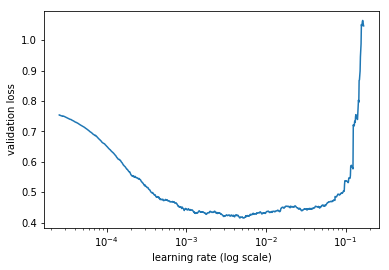

In [552]:
m.lr_find()
m.sched.plot(100)

In [553]:
m.fit(lr, 3)

epoch      trn_loss   val_loss                                  
    0      0.42372    0.335364  
    1      0.413269   0.332118                                  
    2      0.4197     0.331599                                  


[array([0.3316])]

In [554]:
m.fit(lr, 5, cycle_len=1)

epoch      trn_loss   val_loss                                  
    0      0.411401   0.330414  
    1      0.403716   0.329631                                  
    2      0.419745   0.329405                                  
    3      0.406748   0.330357                                  
    4      0.409771   0.329091                                  


[array([0.32909])]

In [555]:
m.fit(lr, 3, cycle_len=4, cycle_mult=2 )

epoch      trn_loss   val_loss                                  
    0      0.414604   0.329597  
    1      0.410078   0.329352                                  
    2      0.412498   0.328962                                  
    3      0.404555   0.329497                                  
    4      0.403148   0.329746                                  
    5      0.40564    0.330611                                  
    6      0.410942   0.331267                                  
    7      0.408081   0.331456                                  
    8      0.391741   0.329032                                  
    9      0.412423   0.331499                                  
    10     0.402537   0.331151                                  
    11     0.395488   0.330901                                  
    12     0.405151   0.332498                                  
    13     0.392242   0.329971                                  
    14     0.405966   0.332608                           

[array([0.34186])]

In [556]:
m.save(modelName)

In [557]:
m.load(modelName)

## Validation

In [558]:
(x,y1)=m.predict_with_targs()

In [559]:
val = p.train.iloc[val_idx]
val[[dep]]
valpred = pd.DataFrame({
    'Close':val.Close,
    'index':val.index,
    'action':val.action,
    'predicted':np.argmax(x,axis=1)
})[['Close','index', 'action','predicted']]
valpred.tail(100)

,Close,index,action,predicted
Timestamp,,,,
2018-06-23 11:01:00,6159.000000,2018-06-23 11:01:00,1,0
2018-06-23 11:02:00,6158.990234,2018-06-23 11:02:00,1,0
2018-06-23 11:03:00,6186.939941,2018-06-23 11:03:00,0,0
2018-06-23 11:04:00,6173.899902,2018-06-23 11:04:00,0,0
2018-06-23 11:05:00,6160.479980,2018-06-23 11:05:00,0,0
2018-06-23 11:06:00,6155.779785,2018-06-23 11:06:00,0,0
2018-06-23 11:07:00,6160.569824,2018-06-23 11:07:00,0,0
2018-06-23 11:08:00,6157.009766,2018-06-23 11:08:00,0,0
2018-06-23 11:09:00,6157.020020,2018-06-23 11:09:00,0,0


Calculate the percent accuracy on the validation set

In [560]:
p.calculate_accuracy(valpred)

{'F1Score': 0.57,
 'totalAccuracy': 0.879,
 'buyAccuracy': 0.164,
 'sellAccuracy': 0.977,
 'totalBuyActions': 1261,
 'successfulBuyPredictions': 207}

In [561]:
p.calculate_net_profit(valpred, 15000, 0)
p.result

{'startClose': 6459.25,
 'endClose': 6128.51,
 'startAmount': 15000,
 'endAmount': 15226.859977781121,
 'buyAndHoldPercentIncrease': -5.12,
 'percentIncrease': 1.512,
 'percentDifference': 6.633,
 'totalTrades': 266}

In [562]:
# p.plot_profit(p.net_profit_df)

In [563]:
p.net_profit_df

,Close,index,action,predicted,buyAmount,sellAmount
Timestamp,,,,,,
2018-06-16 05:41:00,6459.250000,2018-06-16 05:41:00,1,0,15000.000000,0.000000
2018-06-16 05:42:00,6463.000000,2018-06-16 05:42:00,1,0,15000.000000,0.000000
2018-06-16 05:43:00,6478.759766,2018-06-16 05:43:00,0,0,15000.000000,0.000000
2018-06-16 05:44:00,6475.000000,2018-06-16 05:44:00,0,0,15000.000000,0.000000
2018-06-16 05:45:00,6469.160156,2018-06-16 05:45:00,0,0,15000.000000,0.000000
2018-06-16 05:46:00,6469.160156,2018-06-16 05:46:00,0,0,15000.000000,0.000000
2018-06-16 05:47:00,6469.160156,2018-06-16 05:47:00,0,0,15000.000000,0.000000
2018-06-16 05:48:00,6461.339844,2018-06-16 05:48:00,0,0,15000.000000,0.000000
2018-06-16 05:49:00,6459.109863,2018-06-16 05:49:00,0,0,15000.000000,0.000000


## Test

In [564]:
np.argmax(m.predict(True), axis =1)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..., 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 0])

In [565]:
testPred = pd.DataFrame({
    'index':p.test.index,
    'Close':p.test.Close,
    'action':p.test.action, 
    'predicted':np.argmax(m.predict(True), axis =1)
})[['index','Close','action', 'predicted']]
testPred.head(10)

,index,Close,action,predicted
Timestamp,,,,
2018-06-23 12:41:00,2018-06-23 12:41:00,6128.509766,1,0
2018-06-23 12:42:00,2018-06-23 12:42:00,6128.500000,1,0
2018-06-23 12:43:00,2018-06-23 12:43:00,6128.500000,1,0
2018-06-23 12:44:00,2018-06-23 12:44:00,6123.069824,1,0
2018-06-23 12:45:00,2018-06-23 12:45:00,6126.890137,1,0
2018-06-23 12:46:00,2018-06-23 12:46:00,6130.000000,1,0
2018-06-23 12:47:00,2018-06-23 12:47:00,6130.160156,1,0
2018-06-23 12:48:00,2018-06-23 12:48:00,6130.160156,1,0
2018-06-23 12:49:00,2018-06-23 12:49:00,6137.819824,0,0


In [566]:
p.calculate_accuracy(testPred)

{'F1Score': 0.571,
 'totalAccuracy': 0.809,
 'buyAccuracy': 0.181,
 'sellAccuracy': 0.962,
 'totalBuyActions': 980,
 'successfulBuyPredictions': 177}

In [567]:
p.calculate_net_profit(testPred, 15000, 0)
p.result

{'startClose': 6128.51,
 'endClose': 6071.53,
 'startAmount': 15000,
 'endAmount': 15576.234549972756,
 'buyAndHoldPercentIncrease': -0.93,
 'percentIncrease': 3.842,
 'percentDifference': 4.771,
 'totalTrades': 146}

In [568]:
p.net_profit_df

,index,Close,action,predicted,buyAmount,sellAmount
Timestamp,,,,,,
2018-06-23 12:41:00,2018-06-23 12:41:00,6128.509766,1,0,15000.000000,0.000000
2018-06-23 12:42:00,2018-06-23 12:42:00,6128.500000,1,0,15000.000000,0.000000
2018-06-23 12:43:00,2018-06-23 12:43:00,6128.500000,1,0,15000.000000,0.000000
2018-06-23 12:44:00,2018-06-23 12:44:00,6123.069824,1,0,15000.000000,0.000000
2018-06-23 12:45:00,2018-06-23 12:45:00,6126.890137,1,0,15000.000000,0.000000
2018-06-23 12:46:00,2018-06-23 12:46:00,6130.000000,1,0,15000.000000,0.000000
2018-06-23 12:47:00,2018-06-23 12:47:00,6130.160156,1,0,15000.000000,0.000000
2018-06-23 12:48:00,2018-06-23 12:48:00,6130.160156,1,0,15000.000000,0.000000
2018-06-23 12:49:00,2018-06-23 12:49:00,6137.819824,0,0,15000.000000,0.000000


In [569]:
# p.plot_profit(p.net_profit_df)

#### 